**Mini Project** - Use the following dataset to analyze ups and downs in the market and predict 
future stock price returns based on Indian Market data from 2000 to 2020

In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
dataframes = []
stock_name = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        dataframes.append(pd.read_csv(os.path.join(dirname, filename),index_col = 0) )
        stock_name.append(filename)


In [46]:
dataframes[10].head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-18,11.03,11.03,11.03,11.03,10.198853,0
2012-06-19,11.03,11.03,11.03,11.03,10.198853,0
2012-06-20,11.03,11.03,11.03,11.03,10.198853,0
2012-06-21,11.03,11.03,11.03,11.03,10.198853,0
2012-06-22,11.03,11.03,11.03,11.03,10.198853,0


In [47]:
stock_name[100]

'717503.BO.csv'

In [48]:
dataframes[100].shape

(1565, 6)

In [49]:
dataframes[100].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1.565000e+03
mean,7.959144,8.005802,7.929335,7.966709,6.051756,1.969206e+06
std,1.755859,1.757981,1.758535,1.753638,1.079812,6.176801e+06
min,2.480000,2.850000,2.480000,2.850000,2.726316,0.000000e+00
25%,7.600000,7.630000,7.580000,7.600000,5.217708,2.318600e+04
50%,8.400000,8.500000,8.400000,8.400000,6.140487,2.759070e+05
75%,9.250000,9.300000,9.210000,9.260000,6.763847,1.361068e+06
max,11.000000,11.000000,10.000000,10.100000,7.803689,9.816484e+07


In [50]:
dataframes[100].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 2014-03-19 to 2020-06-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1565 non-null   float64
 1   High       1565 non-null   float64
 2   Low        1565 non-null   float64
 3   Close      1565 non-null   float64
 4   Adj Close  1565 non-null   float64
 5   Volume     1565 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 85.6+ KB


Text(0.5, 1.0, 'Closing Price of 717503.BO.csv')

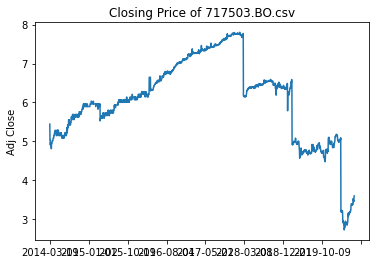

In [51]:
dataframes[100]['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of {stock_name[100]}")

Text(0.5, 1.0, 'Volume of 717503.BO.csv')

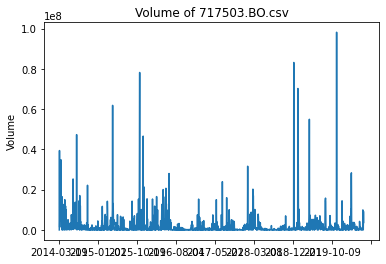

In [52]:
dataframes[100]['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Volume of {stock_name[100]}")

In [53]:
ma_day = [10,50,100,365]
for ma in ma_day:
    for company in dataframes:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

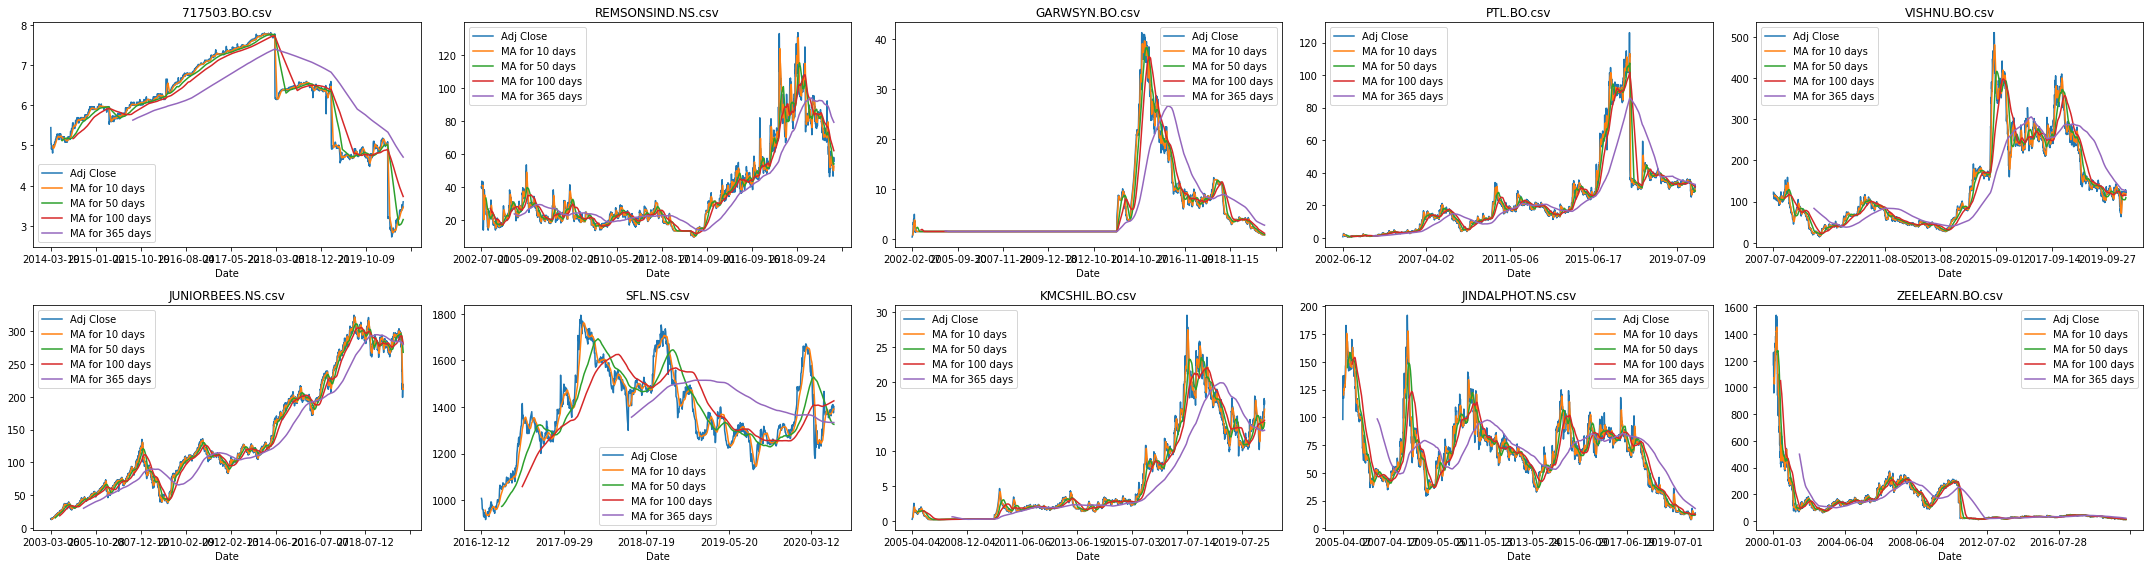

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_figheight(8)
fig.set_figwidth(30)
k = 0; j = 0;
for i in range(100,110):
    dataframes[i][['Adj Close', 'MA for 10 days', 'MA for 50 days', 'MA for 100 days','MA for 365 days']].plot(ax=axes[k,j]).set_title(f"{stock_name[i]}");
    j = j+1;
    if(j==5):
        k=1;
        j=0;
fig.tight_layout()

### Stock Returns:

In [55]:
for company in dataframes:
    company['Daily Return'] = company['Adj Close'].pct_change()

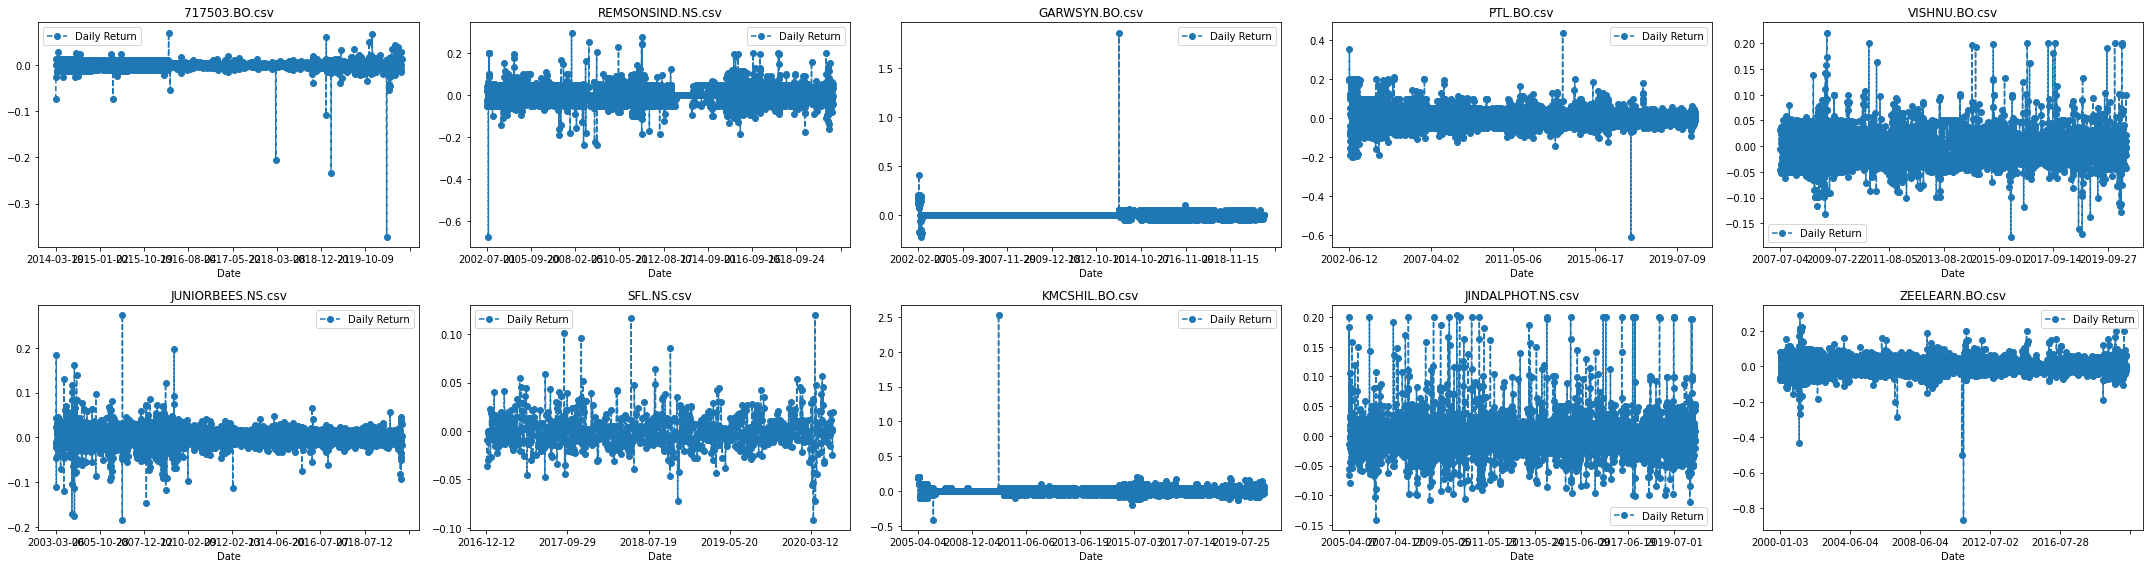

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_figheight(8)
fig.set_figwidth(30)
k = 0; j = 0;
for i in range(100,110):
    dataframes[i][['Daily Return']].plot(ax=axes[k,j], linestyle = '--', marker = 'o').set_title(f"{stock_name[i]}");
    j = j+1;
    if(j==5):
        k=1;
        j=0;
fig.tight_layout()

### Build LSTM Models:

In [57]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf

In [58]:
def build_training_dataset(input_ds):
    # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data = input_ds.filter(items=['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return data, dataset, training_data_len

training_data_df, training_dataset_np, training_data_len = build_training_dataset(dataframes[100])
dataset=training_dataset_np
data=training_data_df

In [59]:
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

scaler, scaled_data = scale_the_data(training_dataset_np)

In [60]:
def split_train_dataset(training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            print('.')
            
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
   
    return x_train, y_train


x_train,y_train = split_train_dataset(training_data_len)

.
.


In [61]:
def build_lstm_model(x_train,y_train):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model 

lstm_model = build_lstm_model(x_train,y_train)

1427/1427 [==============================] - 69s 46ms/step - loss: 0.0028


In [62]:
def create_testing_data_set(model, scaler, training_data_len,test_data_len):

    test_data = scaled_data[training_data_len - test_data_len: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])
    
    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    rmse
    return (x_test, y_test, predictions, rmse)

TEST_DATA_LENGTH = 100
x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


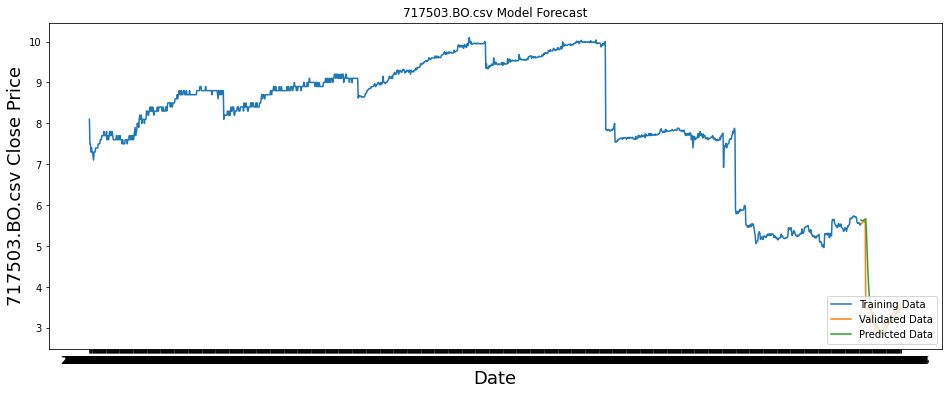

In [63]:
def plot_predictions(stock, data,training_data_len):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid
    
#Test the function
valid = plot_predictions(stock_name[100],data,training_data_len)

.
.
3242/3242 [==============================] - 149s 45ms/step - loss: 0.0010


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


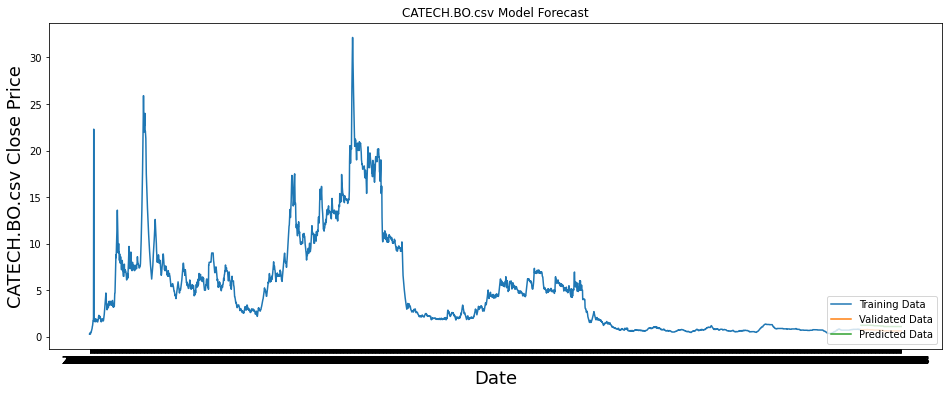

Test RMSE: 0.473
.
.
3407/3407 [==============================] - 154s 44ms/step - loss: 0.0015


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


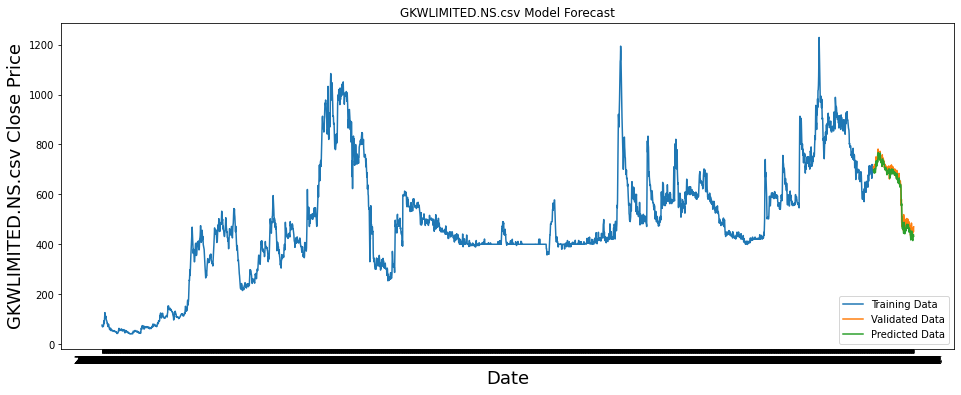

Test RMSE: 21.147
.
.
3816/3816 [==============================] - 172s 44ms/step - loss: 0.0016


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


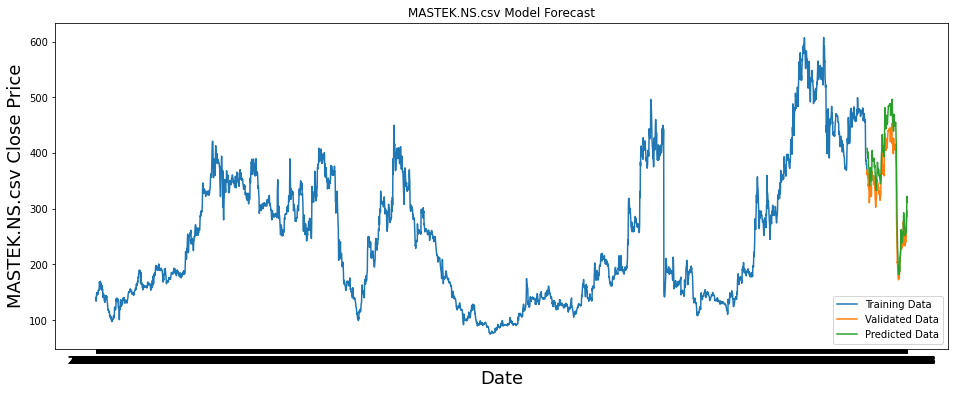

Test RMSE: 35.573
.
.
2970/2970 [==============================] - 135s 44ms/step - loss: 0.0015


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


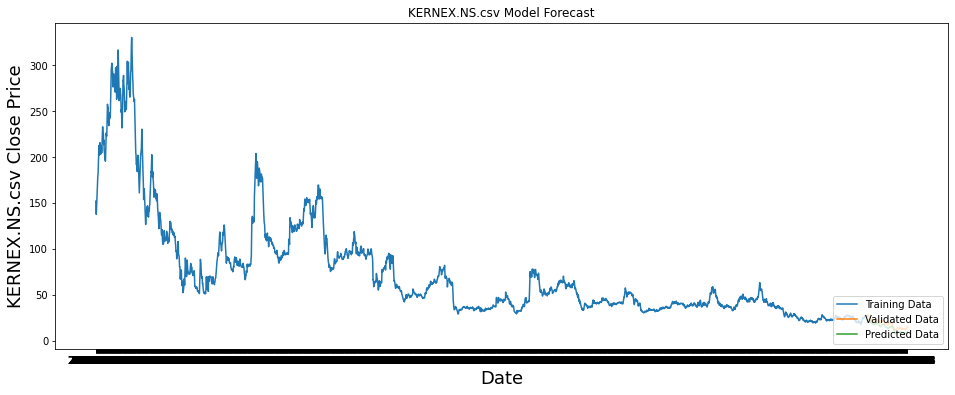

Test RMSE: 4.010
.
.
805/805 [==============================] - 39s 44ms/step - loss: 0.0032


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


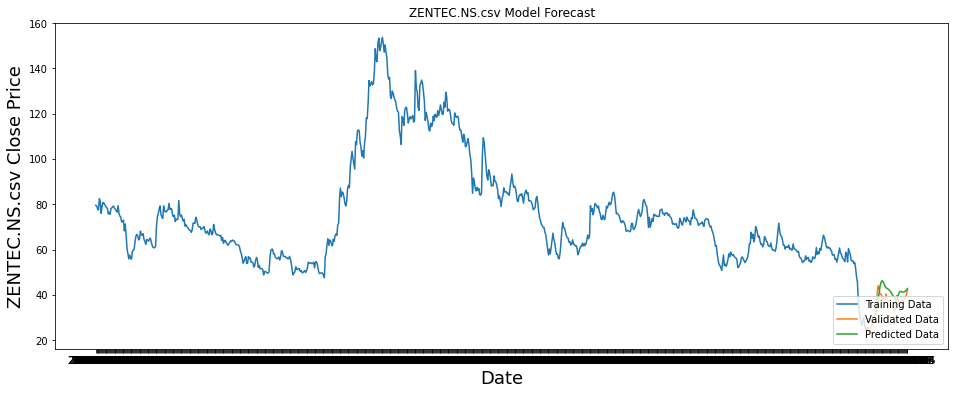

Test RMSE: 4.654
.
.
2818/2818 [==============================] - 128s 44ms/step - loss: 0.0018


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


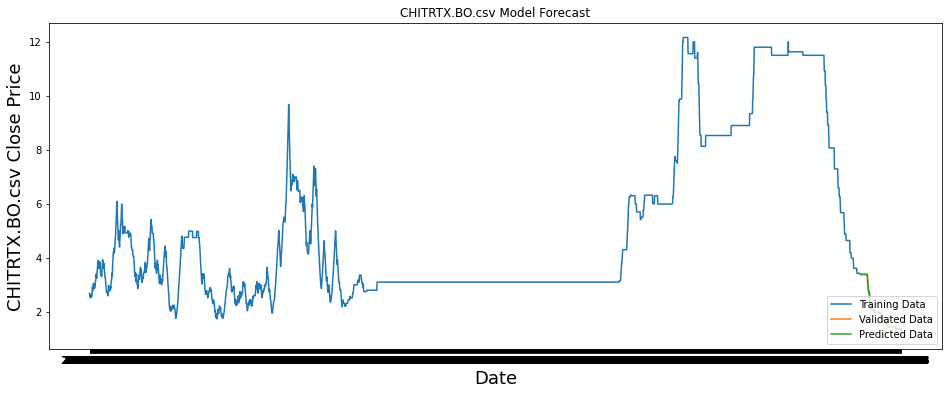

Test RMSE: 0.075
.
.
 544/1594 [=========>....................] - ETA: 46s - loss: 0.0039

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
i = 0
TEST_DATA_LENGTH = 111
error_scores = {}
trained_model = {}
for stock in stock_name:
    df= dataframes[i]
    dataframes[i].dropna(inplace=True)
    i= i+1
    training_data_df, training_dataset_np, training_data_len = build_training_dataset(df) #Build the Training Dataset
    dataset=training_dataset_np
    data=training_data_df
    scaler, scaled_data = scale_the_data(training_dataset_np) #Scale the data
    x_train,y_train = split_train_dataset(training_data_len) #split the data
    lstm_model = build_lstm_model(x_train,y_train) #build the LSTM model
    trained_model[stock] = lstm_model
    x_test,y_test, predictions, rmse = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH ) #create testing dataset and predictions
    valid = plot_predictions(stock,data,training_data_len) #plot predictions
    valid   # Show the valid and predicted prices
    rmse = sqrt(mean_squared_error(valid['Close'], valid['Predictions']))
    print('Test RMSE: %.3f' % (rmse))
    error_scores[stock] = rmse

print(error_scores)